# Flower Classification

**Exploracion de datos y Preprocesamiento**

**Yalila Aljure Jimenez**

email: yalila.aljure@udea.edu.co

CC. 5288540



**IMPORTING LIBRARIES**

In [ ]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [ ]:
import keras
keras.__version__

'2.6.0'

In [ ]:
!pip install mlflow

     |████████████████████████████████| 14.6 MB 79 kB/s 
     |████████████████████████████████| 170 kB 51.7 MB/s 
     |████████████████████████████████| 636 kB 40.2 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 79 kB 7.6 MB/s 
     |████████████████████████████████| 1.1 MB 48.0 MB/s 
     |████████████████████████████████| 146 kB 52.7 MB/s 
     |████████████████████████████████| 75 kB 5.1 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158172 sha256=368a234a1f320b45d7a5975d26b19874ab74d2d2285fd45d57ae089f7320c1e3
  Stored in directory: /root/.cache/pip/wheels/be/5d/0a/9e13f53f4f5dfb67cd8d245bb7cdffe12f135846f491a283e3
  Created wheel for databricks-cli: filename=databricks_cli-0.15.0-py3-none-any.whl size=105260 sha256=d329af28b5a7a8189475ed2388e7bb0a160f47448fcee26dda2e129f7412d4c8

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import pathlib
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import pyplot as plt
import random

from keras.layers import Conv2D, Dropout, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense, InputLayer, Input
from keras.models import Sequential, Model
import mlflow
import mlflow.keras

**LOAD DATA**

In [ ]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

--2021-08-26 18:17:58--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 74.125.23.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  49.4MB/s    in 4.4s    

2021-08-26 18:18:03 (49.4 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [ ]:
# Unzipping Data
!gunzip flower_photos.tgz

In [ ]:
!tar -xvf flower_photos.tar

**Plotting Images**

In [ ]:
data_dir = pathlib.Path('flower_photos')
folder = list(data_dir.glob('*'))
images = list(data_dir.glob('*/*.jpg')) #list of all images (full path)

In [ ]:
len(images) # Number of images

3670

In [ ]:
fig = plt.figure(figsize=(20, 20))
iterable = np.array(random.sample(range(1, 3670), 54)) # Choosing 54 random images
for i in range(54):
    plt.subplot(9, 6, i+1)
    j = iterable[i]
    plt.title(str(images[j]).split('/')[-1], fontsize=10) # file name and disply as title
    plt.imshow(PIL.Image.open(images[j])) # Displaying Image
    ax = plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

**Parameters**

In [ ]:
image_size = 143 # Setting the size of the images

**Imagen Preprocessing**

Data Augmantation

Original source is not partitioned. The test set will be fixed at 20% of the entire dataset. The rest of the dataset will be used for training (0.8) and validation (0.2).

In [ ]:
idg_flip = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
    validation_split = 0.2
)

In [ ]:
flower_gen_train = idg_flip.flow_from_directory(data_dir,
                                    target_size=(image_size, image_size),
                                    subset='training',
                                    class_mode='categorical',
                                    shuffle=True,
                                    seed=123
                                    )

Found 2939 images belonging to 5 classes.


In [ ]:
flower_gen_test = idg_flip.flow_from_directory(data_dir,
                                    target_size=(image_size, image_size),
                                    subset='validation',
                                    class_mode='categorical',
                                    shuffle=True,
                                    seed=123
                                    )

Found 731 images belonging to 5 classes.


**VGGNet**

In [ ]:
# Instanciate and empty model
model = Sequential()
# First Convolutional Layer
model.add(Conv2D(64, kernel_size=(3,3), activation='relu',padding='same',input_shape=(image_size,image_size,3))) # 2D Convolution layer, filters = 64
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(Conv2D(64, kernel_size=(3,3), activation='relu',padding='same')) # 2D Convolution layer, filters = 64
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(BatchNormalization()) 
# Second Convolutional Layer
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')) # 2D Convolution layer, filters = 128
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(Conv2D(128, kernel_size=(3,3), activation='relu',padding='same')) # 2D Convolution layer, filters = 128
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(BatchNormalization()) 
# Third Convolutional Layer
# model.add(Conv2D(256, kernel_size=(3,3), activation='relu',padding='same')) # 2D Convolution layer, filters = 256
# model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
# model.add(Conv2D(256, kernel_size=(3,3), activation='relu',padding='same')) # 2D Convolution layer, filters = 256
# model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
# model.add(Conv2D(256, kernel_size=(3,3), activation='relu',padding='same')) # 2D Convolution layer, filters = 256
# model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
# model.add(BatchNormalization()) 
# Fourth Convolutional Layer
# model.add(Conv2D(512, kernel_size=(3,3), activation='relu',padding='same')) # 2D Convolution layer, filters = 512
# model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
# model.add(Conv2D(512, kernel_size=(3,3), activation='relu',padding='same')) # 2D Convolution layer, filters = 512
# model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
# model.add(Conv2D(512, kernel_size=(3,3), activation='relu',padding='same')) # 2D Convolution layer, filters = 512
# model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
# model.add(BatchNormalization()) 
# Fith convolutional layer 
# model.add(Conv2D(512, kernel_size=(3,3), activation='relu',padding='same')) # 2D Convolution layer, filters = 512
# model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
# model.add(Conv2D(512, kernel_size=(3,3), activation='relu',padding='same')) # 2D Convolution layer, filters = 512
# model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
# model.add(Conv2D(512, kernel_size=(3,3), activation='relu',padding='same')) # 2D Convolution layer, filters = 512
# model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
# model.add(BatchNormalization()) 
# 1st dense layer
model.add(Flatten()) 
model.add(Dense(4096))
# Dropout
model.add(Dropout(0.5)) 
model.add(Activation('relu'))
# 2nd Dense Layer
model.add(Dense(4096))
# Dropout
model.add(Dropout(0.5))
# Normalization
model.add(BatchNormalization()) 
model.add(Activation('relu'))
# Output softmax layer
model.add(Dense(5))
model.add(Activation('softmax')) 

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 143, 143, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 71, 71, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 35, 35, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 35, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0

In [ ]:
mlflow.keras.autolog()

In [ ]:
Result = model.fit(flower_gen_train, validation_data=flower_gen_test,
                    epochs=20, verbose=1, shuffle=True)

2021/08/26 18:20:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0b070878a0504bdea302aa6bccff2a49', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Epoch 1/20
92/92 [==============================] - 31s 339ms/step - loss: 1.2362 - accuracy: 0.5219 - val_loss: 2.1341 - val_accuracy: 0.2462
Epoch 2/20
92/92 [==============================] - 31s 332ms/step - loss: 1.2081 - accuracy: 0.5427 - val_loss: 1.6497 - val_accuracy: 0.3105
Epoch 3/20
92/92 [==============================] - 31s 335ms/step - loss: 1.1470 - accuracy: 0.5689 - val_loss: 1.6310 - val_accuracy: 0.3680
Epoch 4/20
92/92 [==============================] - 31s 332ms/step - loss: 1.0950 - accuracy: 0.5794 - val_loss: 1.2594 - val_accuracy: 0.4925
Epoch 5/20
92/92 [==============================] - 30s 330ms/step - loss: 1.0606 - accuracy: 0.5931 - val_loss: 1.1839 - val_accuracy: 0.5568
Epoch 6/20
92/92 [==============================] - 30s 328ms/step - loss: 1.0016 - accuracy: 0.6159 - val_loss: 1.0639 - val_accuracy: 0.5882
Epoch 7/20
92/92 [==============================] - 31s 335ms/step - loss: 0.9818 - accuracy: 0.6356 - val_loss: 1.1465 - val_accuracy: 0.5636

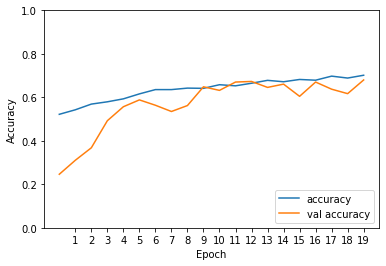

In [ ]:
plt.plot(Result.history['accuracy'], label='accuracy')
plt.plot(Result.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(range(1,20)))
plt.ylim([0, 1])
plt.legend(loc='lower right')